In [121]:
import matplotlib.pylab as plt   # That gives plotting, and the next line makes plots appear inline in notebook
from matplotlib.animation import FuncAnimation
%matplotlib inline 
plt.rcParams['figure.dpi'] = 500
plt.rcParams["errorbar.capsize"] = 5

import numpy as np  # That gives numerical arrays and tools for manipulating them

#### Define tuning curves

In [71]:
def gaussian(mu,sigma, x):   
    maxrate = 300 # max firing rate
    f = maxrate*np.exp(-0.5*((x-mu)/sigma)**2)
    return f

def cockroach_tuning(stim_dir, cell_num):
    
    if cell_num == 0:
        mu = 45
        sigma = 5
        f = gaussian(mu, sigma, stim_dir)
    elif cell_num == 1:
        mu = 45
        sigma = 10
        f = gaussian(mu, sigma, stim_dir) 
    else:
        mu = 30
        sigma = 10
        f1 = gaussian(mu, sigma, stim_dir)
        mu = 60
        f2 = gaussian(mu, sigma, stim_dir)
        f = (f1 + f2)

    return f

Constants are entered here. You can control:
- The number of trials (ntrials)
- The duration of each trial, in milliseconds (nmsec)
- The number of directions the cell is stimulated from (numDirs)

The maximum direction (maxDir) and the number of cells (numCells) are constants that shouldn't be changed

In [124]:
ntrials = 100
nmsec = 301 # 301 instead of 300 so the plots look better
numDirs = 30 # due to use of integer division, this code works well only when numdirs is a factor of maxdir
numCells = 3 # lets you enumerate each distinct cell response
maxDir = 90 # the angle goes from 0 to a maximum of 90


## Generate spike train

In [125]:
spiketrain = np.zeros((ntrials,nmsec, numDirs, numCells)) # output data for each trial, at each millisecond, for each direction represented, for each cell
stimDirs = np.arange(0, maxDir, maxDir / numDirs, dtype = np.int32) # evenly spaced values to stimulate, the division 'maxdir / numDirs' is the main reason numDirs should be a factor of maxDir
times = np.arange(nmsec) # array of time points (1 msec apart)
tau = 100      # adaptation time constant in msec
delta_t = 0.001  # time bin, in seconds (1 msec)

rng = np.random.default_rng()

for l in np.arange(numCells):
    for k in np.arange(numDirs):
        rate = cockroach_tuning(stimDirs[k], l)
        ratelist = rate*np.exp(-times/tau)
        for j in np.arange(ntrials):
            for i in np.arange(nmsec):
                    spiketrain[j,i,k,l] = np.round(rng.uniform(0,1,1) + ratelist[i]*delta_t -1/2)

## 1.

Angles of 30, 45, and 60 degrees were chosen to be most representative of each plot while still keeping the amount of plots low. The three are good choices to represent the broader pattern of spikes that appears, and using the same angles for all three plots makes comparisons made between cell types more meaningful.

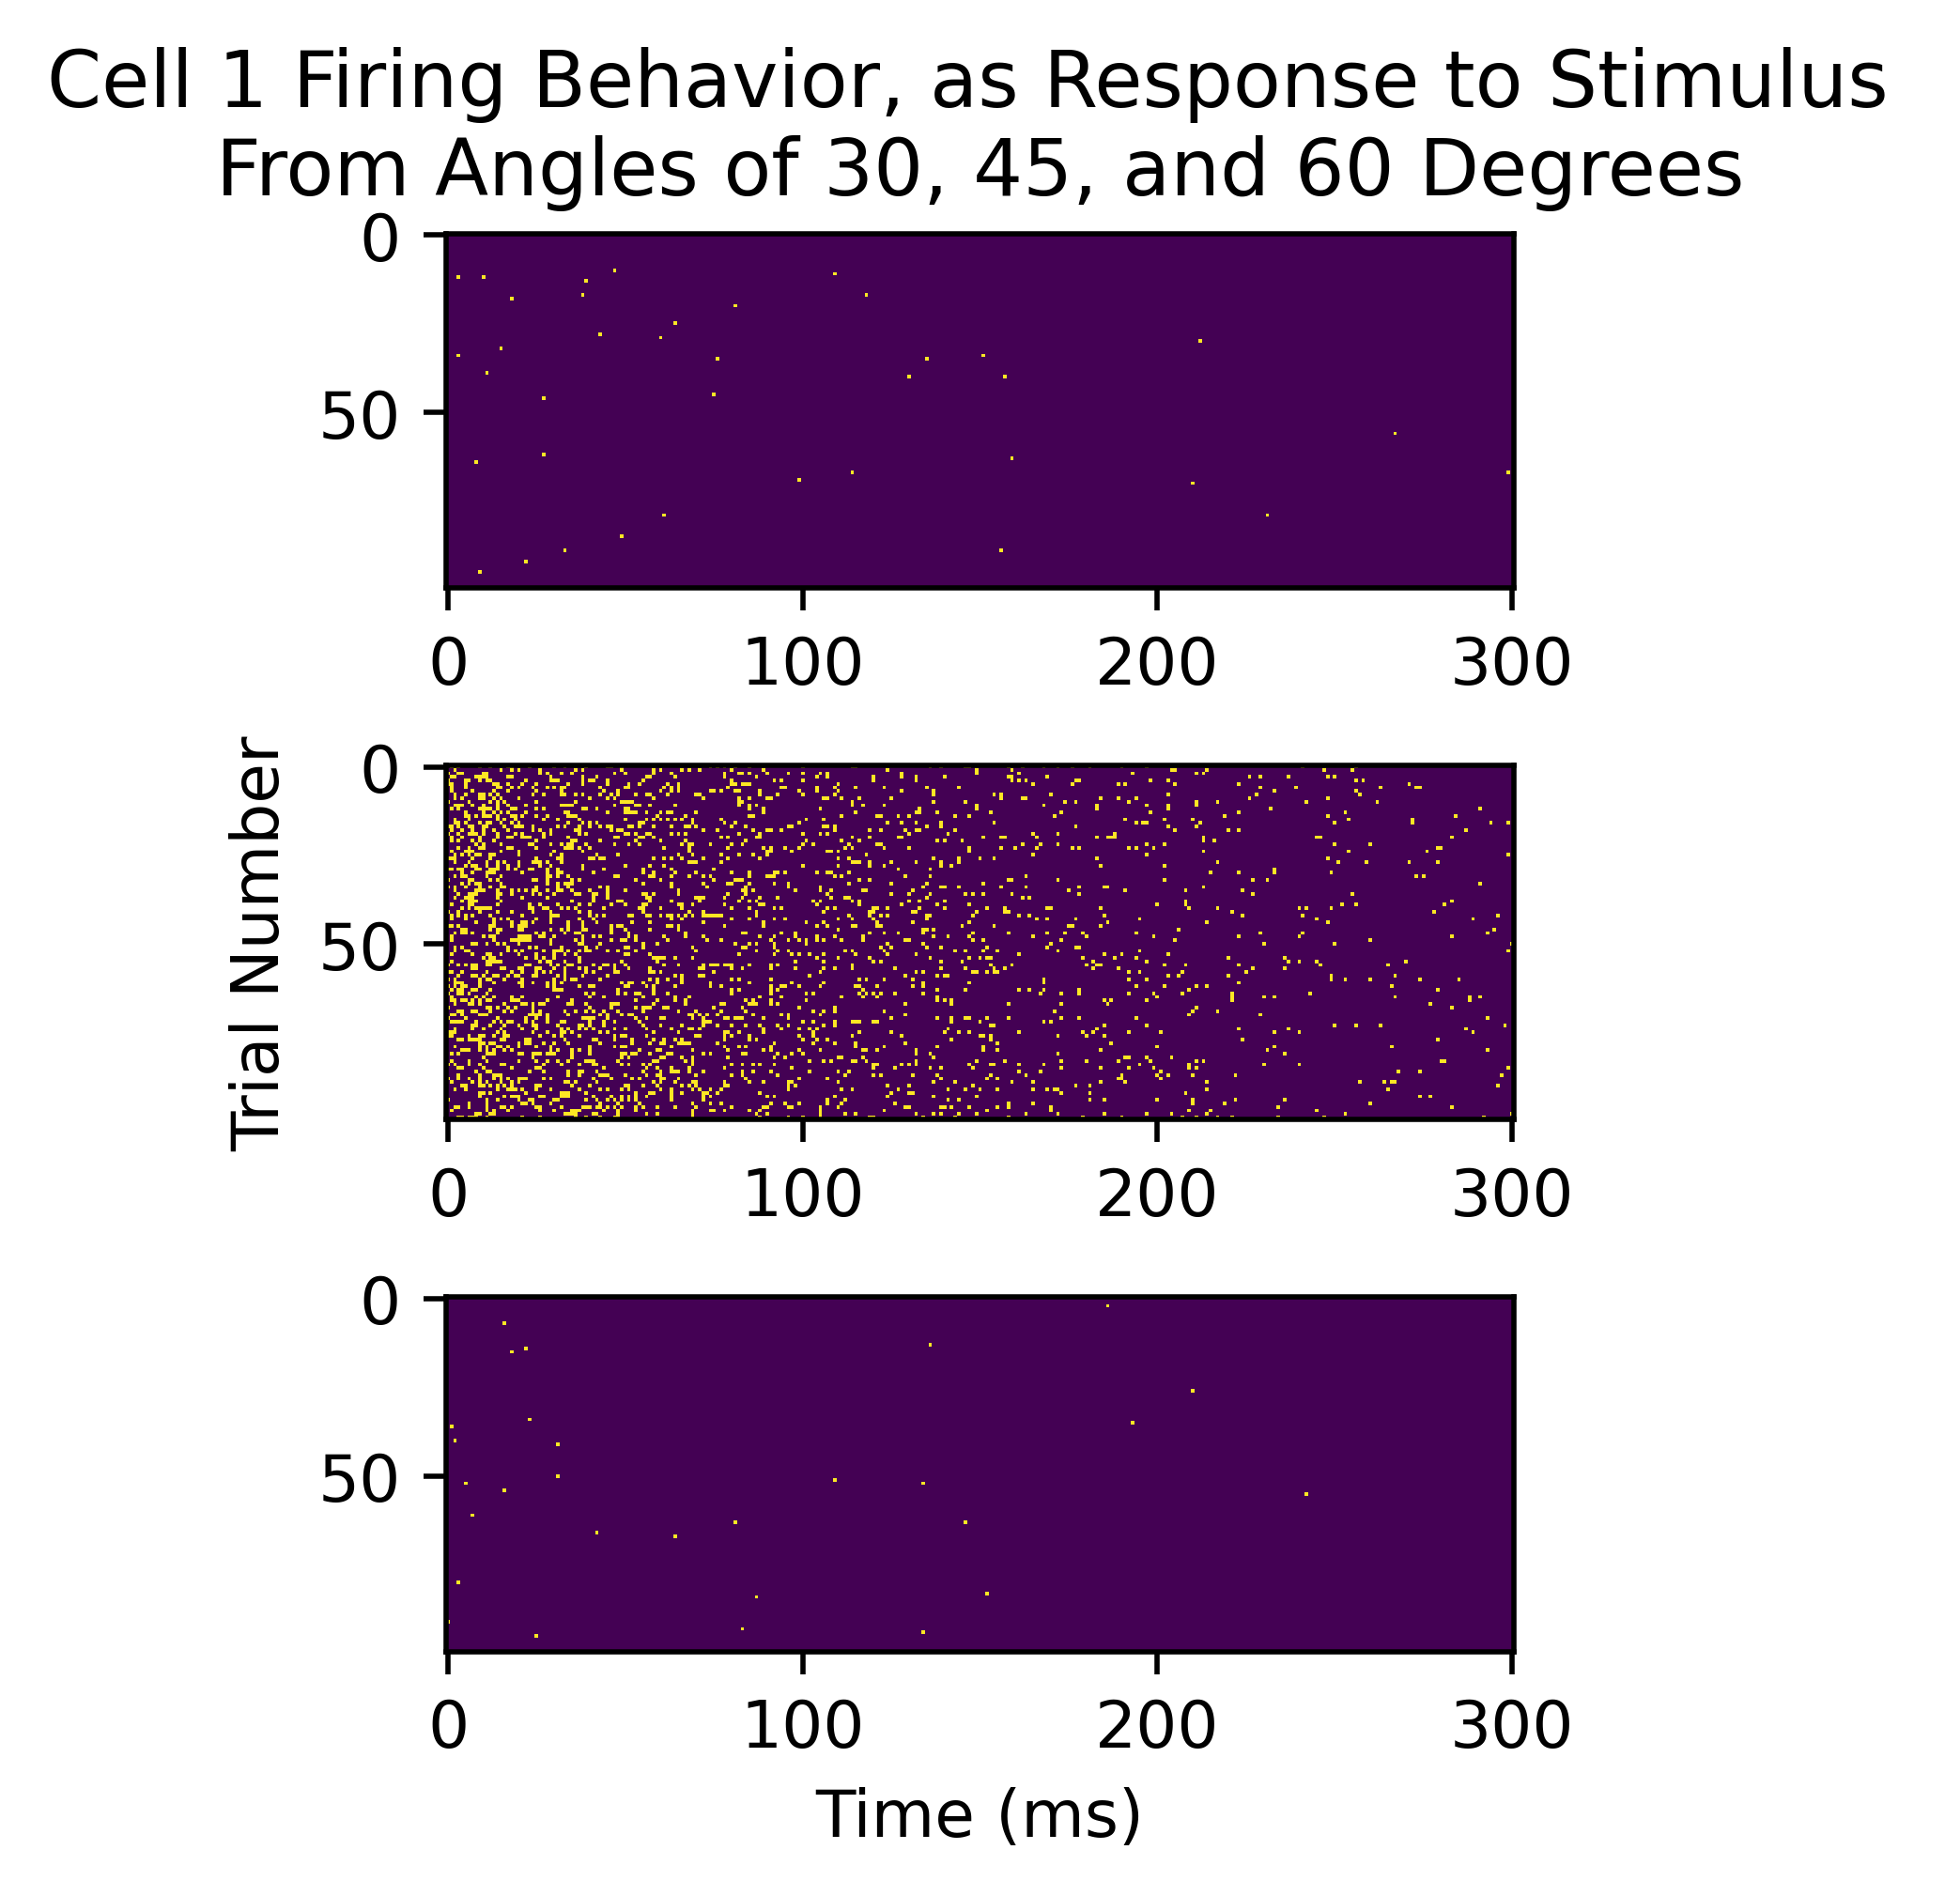

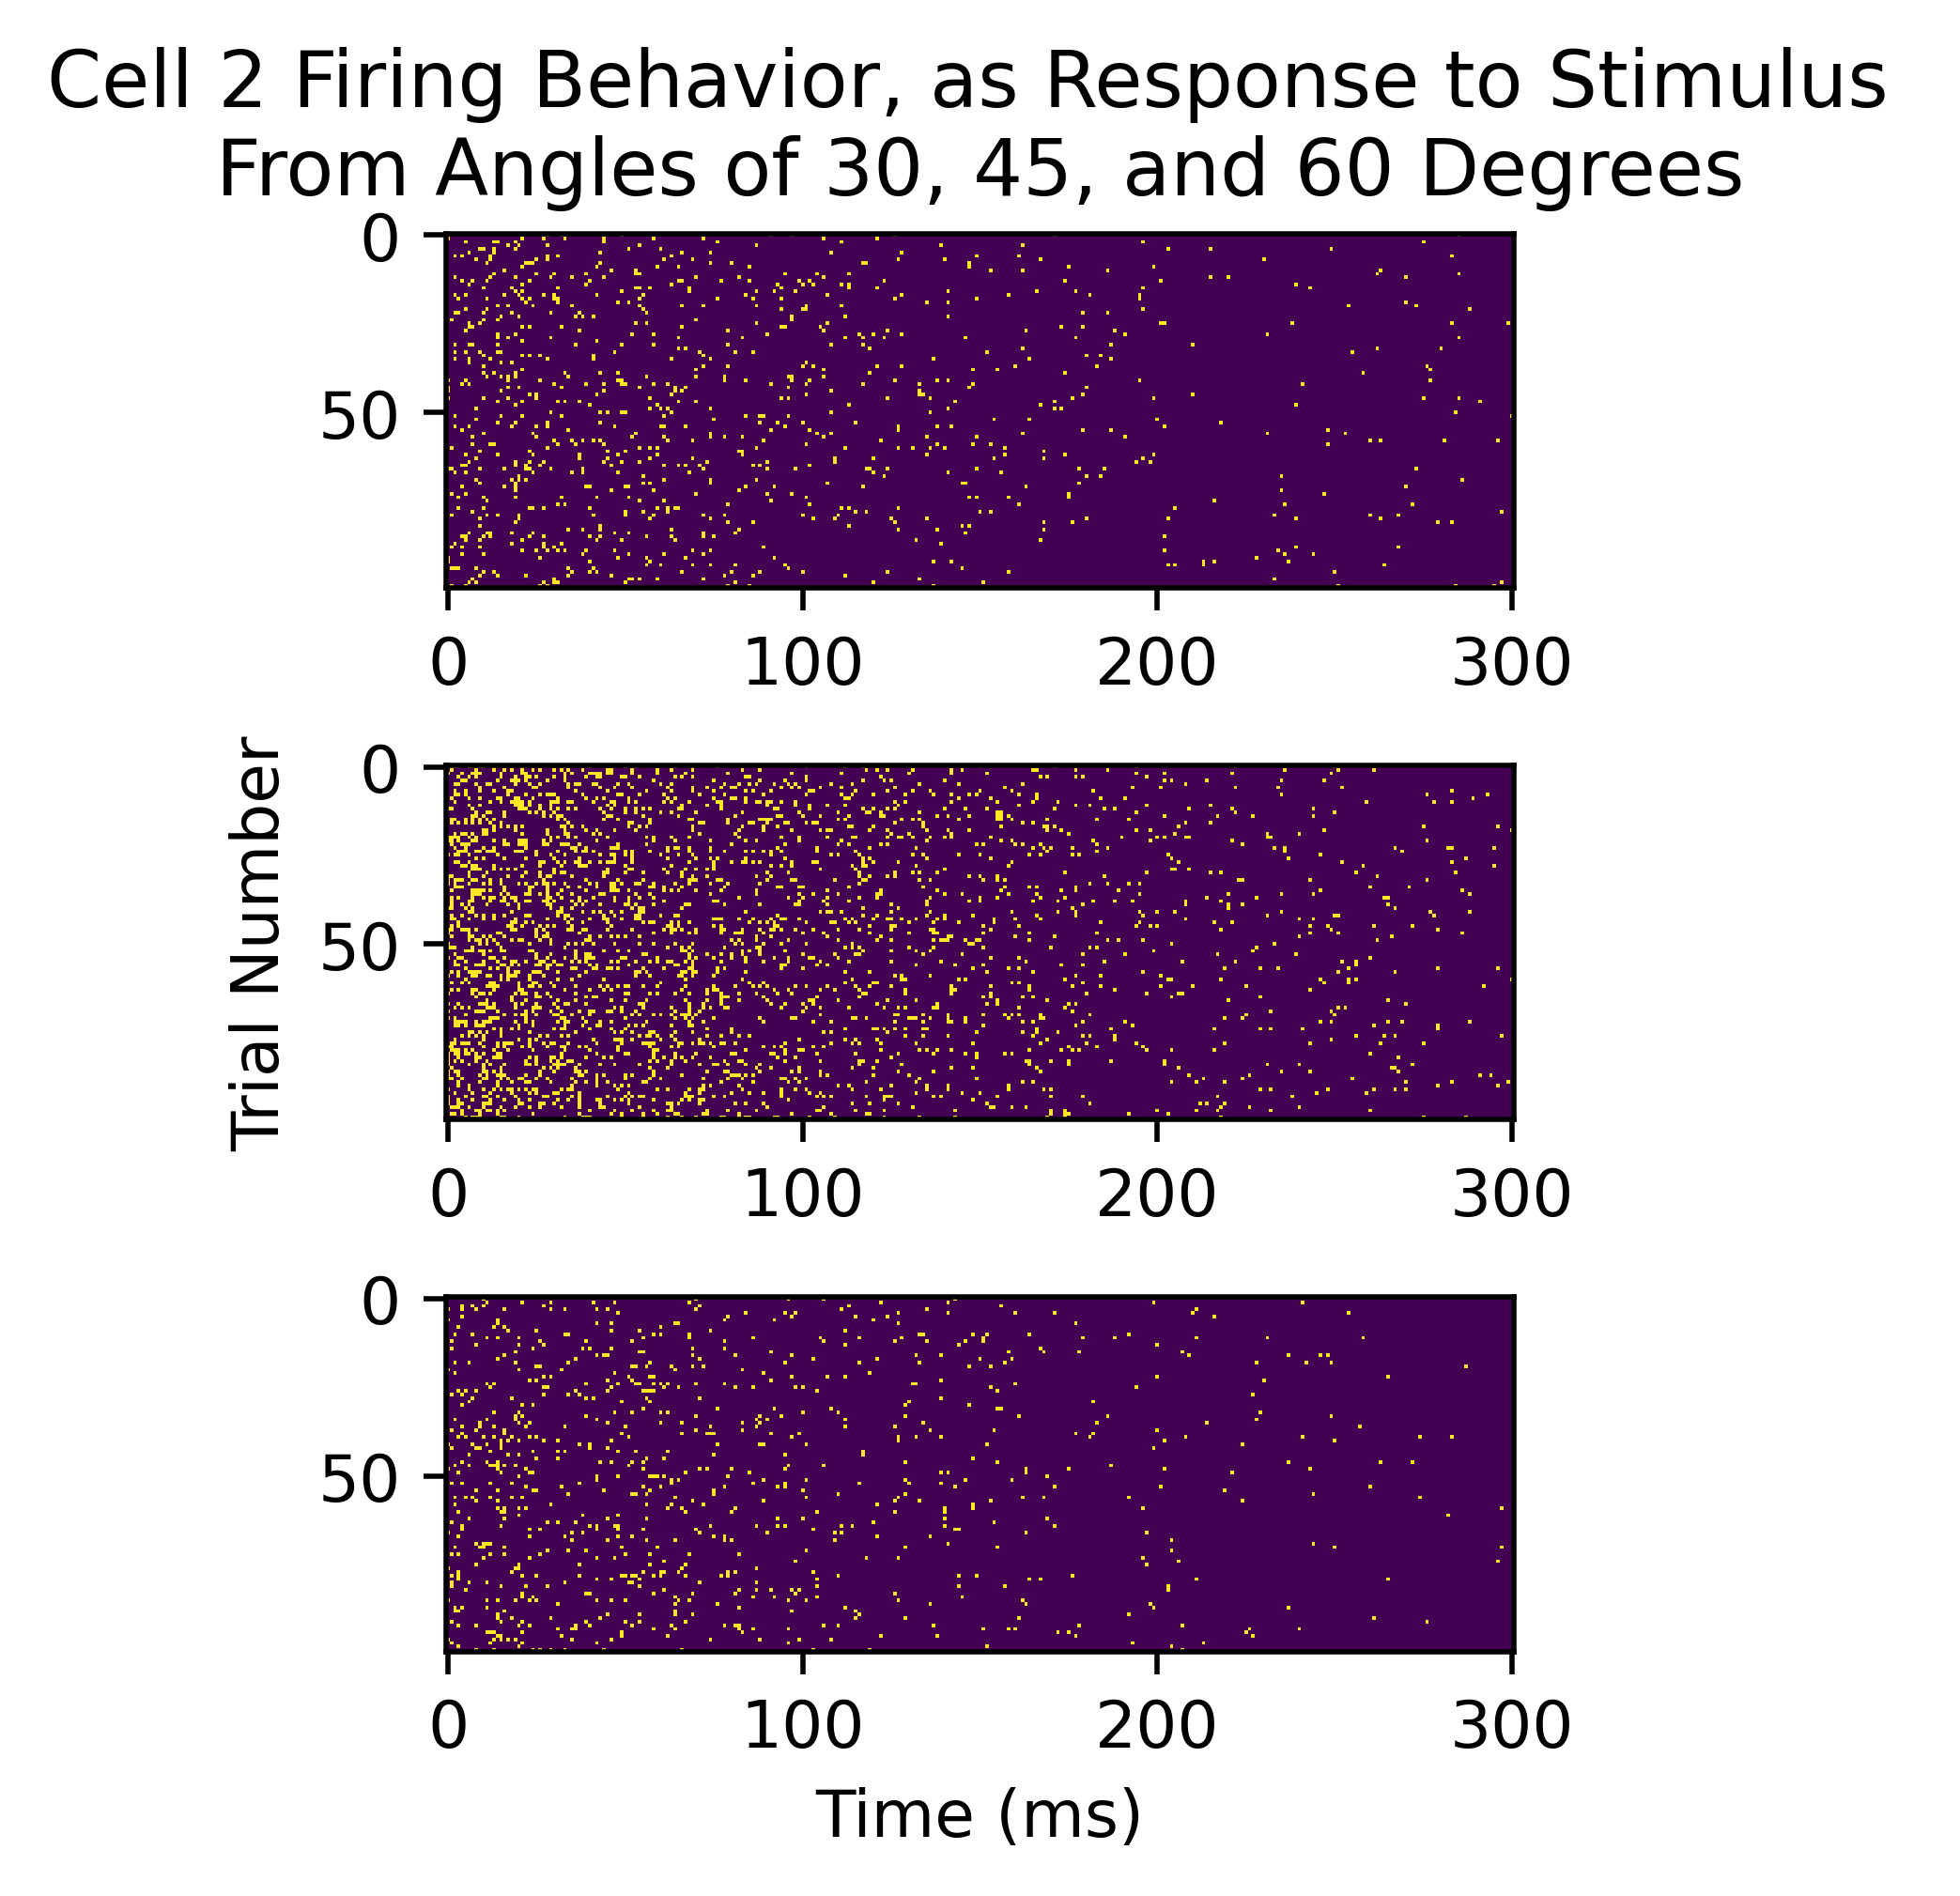

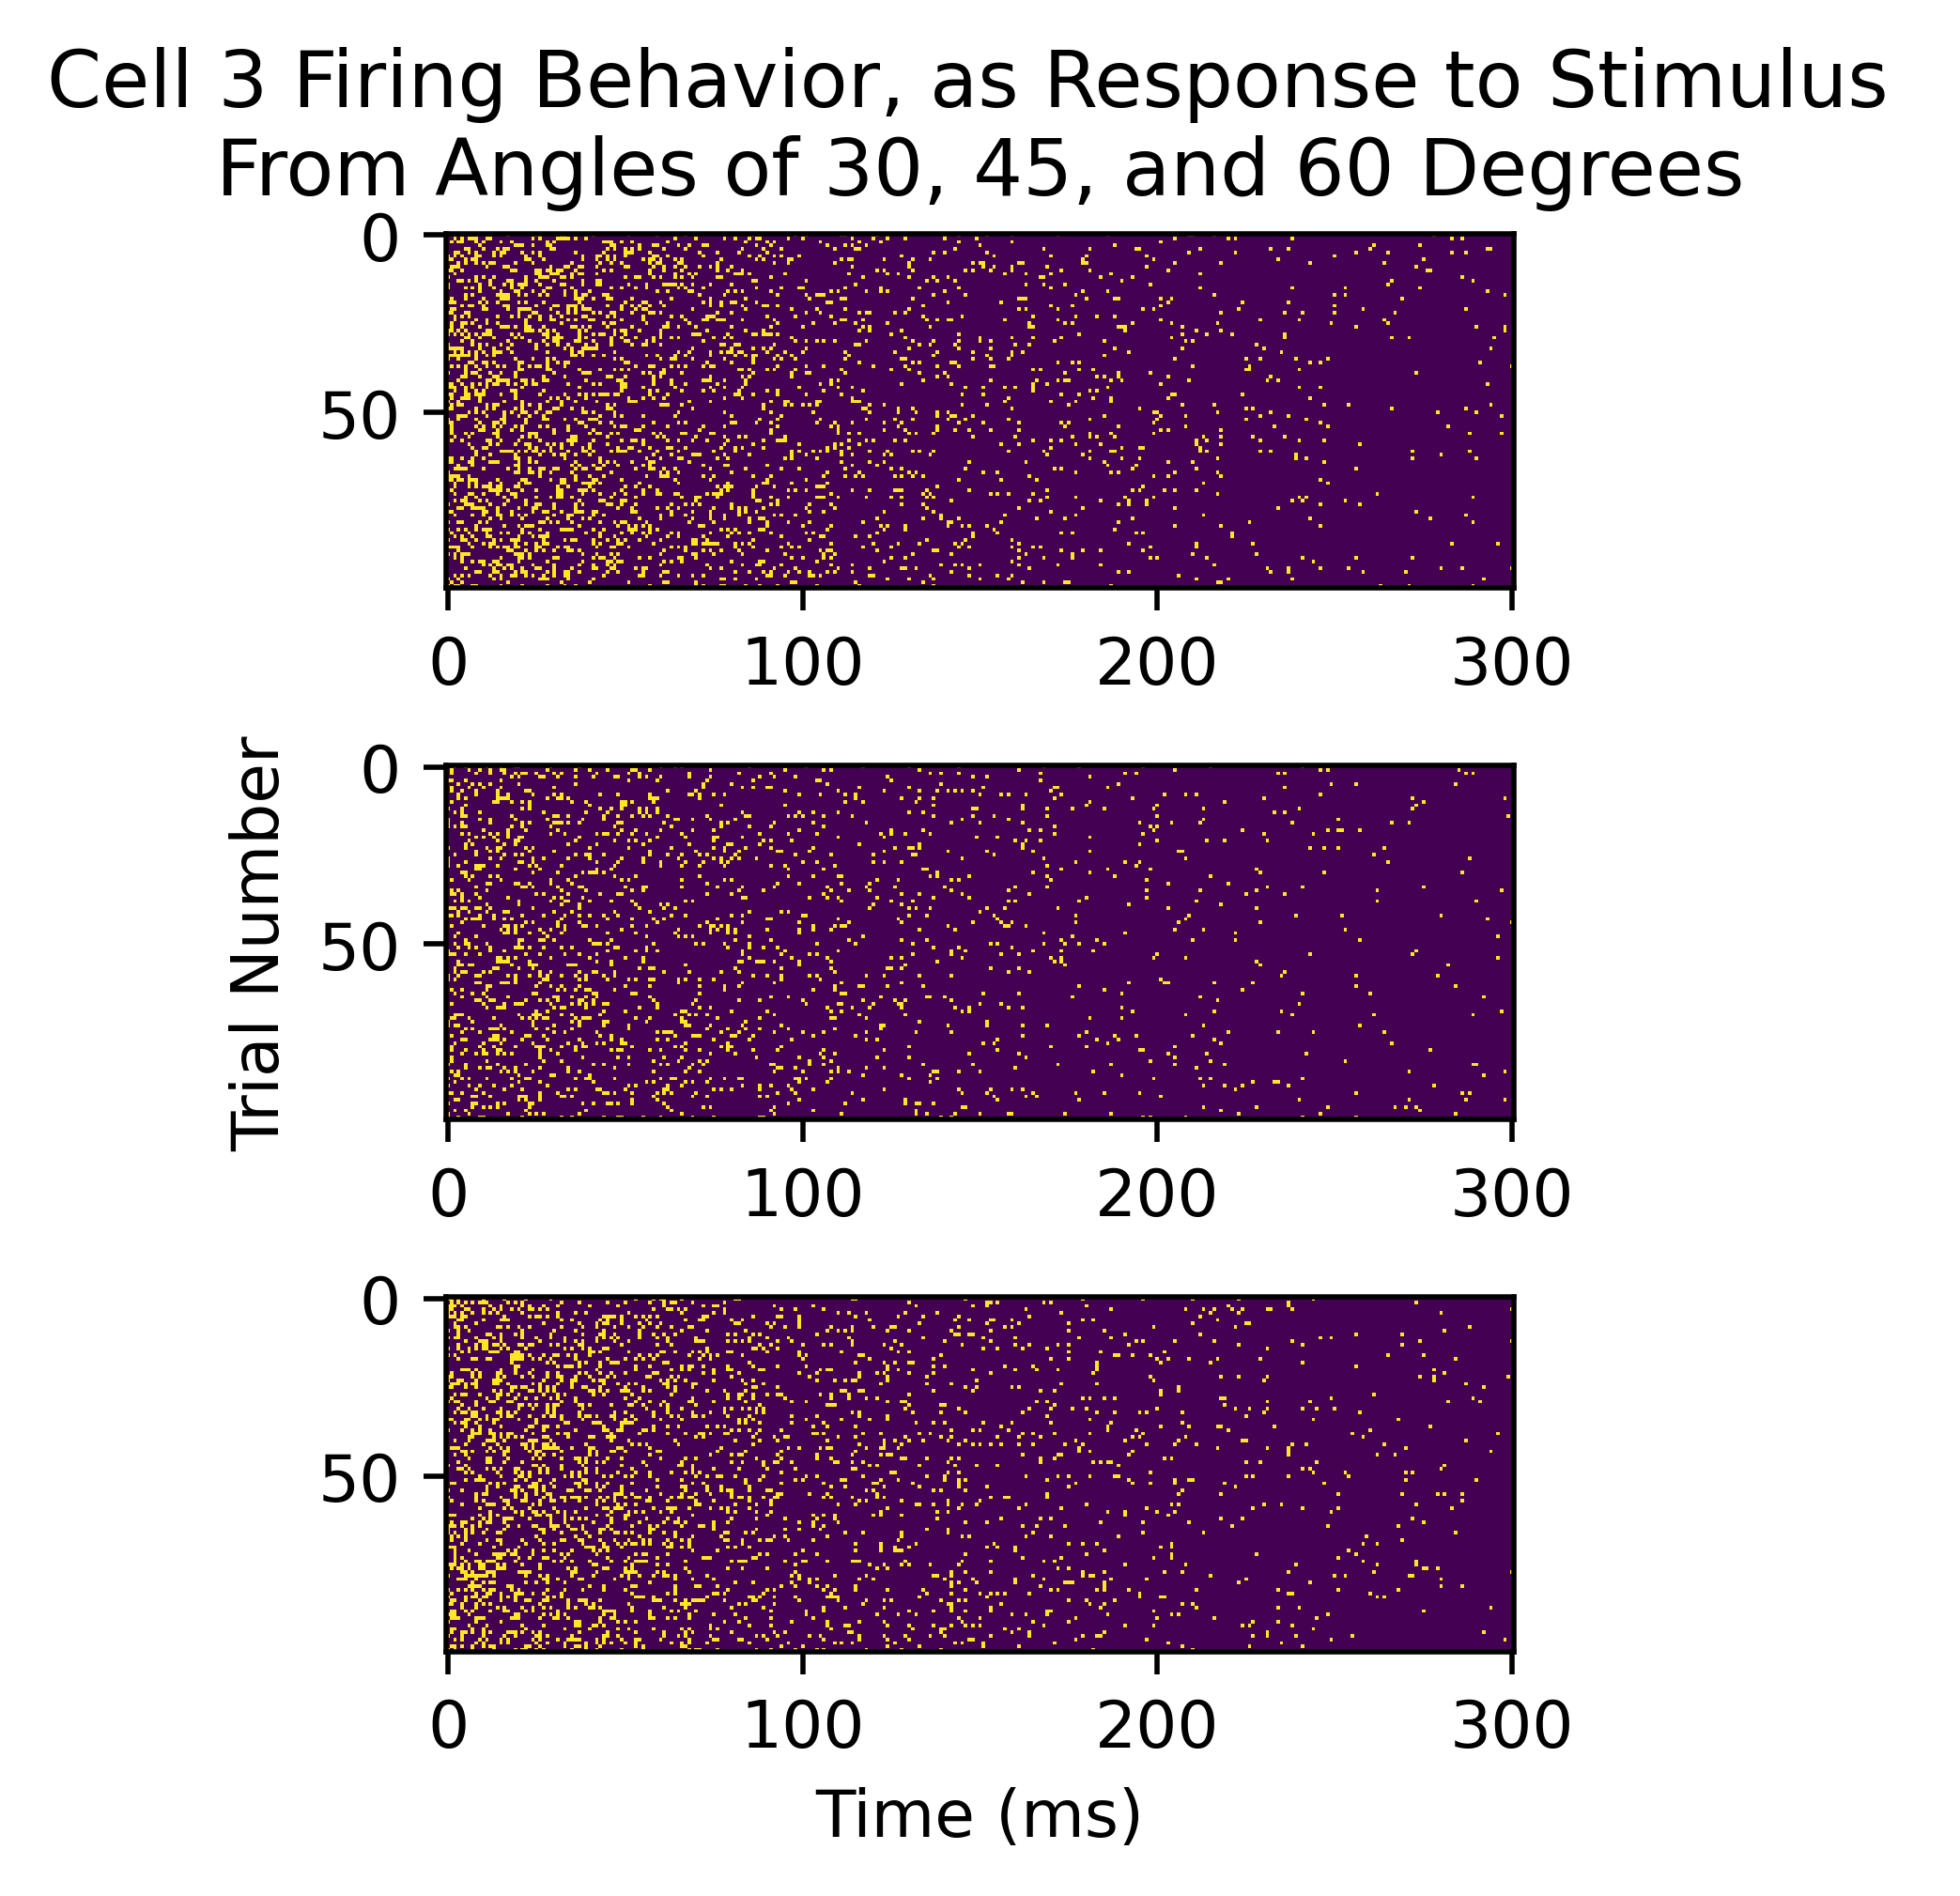

In [126]:
angles = np.array([30,45,60]) # the angles chosen to be displayed in each plot
idx = angles * numDirs/maxDir # the indexes of those angles in the spiketrain[:,:] array
idx = idx.astype(int) # allows use as indexes

for i in range(numCells):
    plt.figure(i)
    plt.subplots_adjust(hspace = .5)
    for j in range(len(idx)):
        plt.subplot(numCells, 1, j + 1)
        if j == 0:
            plt.title('Cell ' + str(i + 1) + ' Firing Behavior, as Response to Stimulus \nFrom Angles of 30, 45, and 60 Degrees')
        plt.imshow(spiketrain[:,:,idx[j],i])
        
        if j == 2:
            plt.xlabel('Time (ms)')
        if j == 1:
            plt.ylabel('Trial Number')

## Collecting means and standard deviations for each direction and cell    

In [127]:
# first dim of normalized sums represents trial, second represents the timebins, third represents direction, fourth represents the cell
sums = np.sum(spiketrain,1) # sum along each trial the number of fires
norm_sums = sums / nmsec
means = np.mean(norm_sums, axis = 0) # takes the mean of normalized amount of spikes over all the trials
stds = np.std(norm_sums, axis = 0) # takes the standard deviations of normalized amount of spikes over all the trials
within_std = (means - stds <= norm_sums) * (means + stds >= norm_sums) # multiplication here is elementwise, essentially an 'and'
for i in np.arange(numCells):
    print('Cell ' + str(i + 1) + ' sums within one standard deviation of the mean: ~' + str(np.round(100 * np.sum(within_std[:,:,i])/(ntrials * numDirs), 2)) + '%')

Cell 1 sums within one standard deviation of the mean: ~88.53%
Cell 2 sums within one standard deviation of the mean: ~77.77%
Cell 3 sums within one standard deviation of the mean: ~68.37%


## 2.

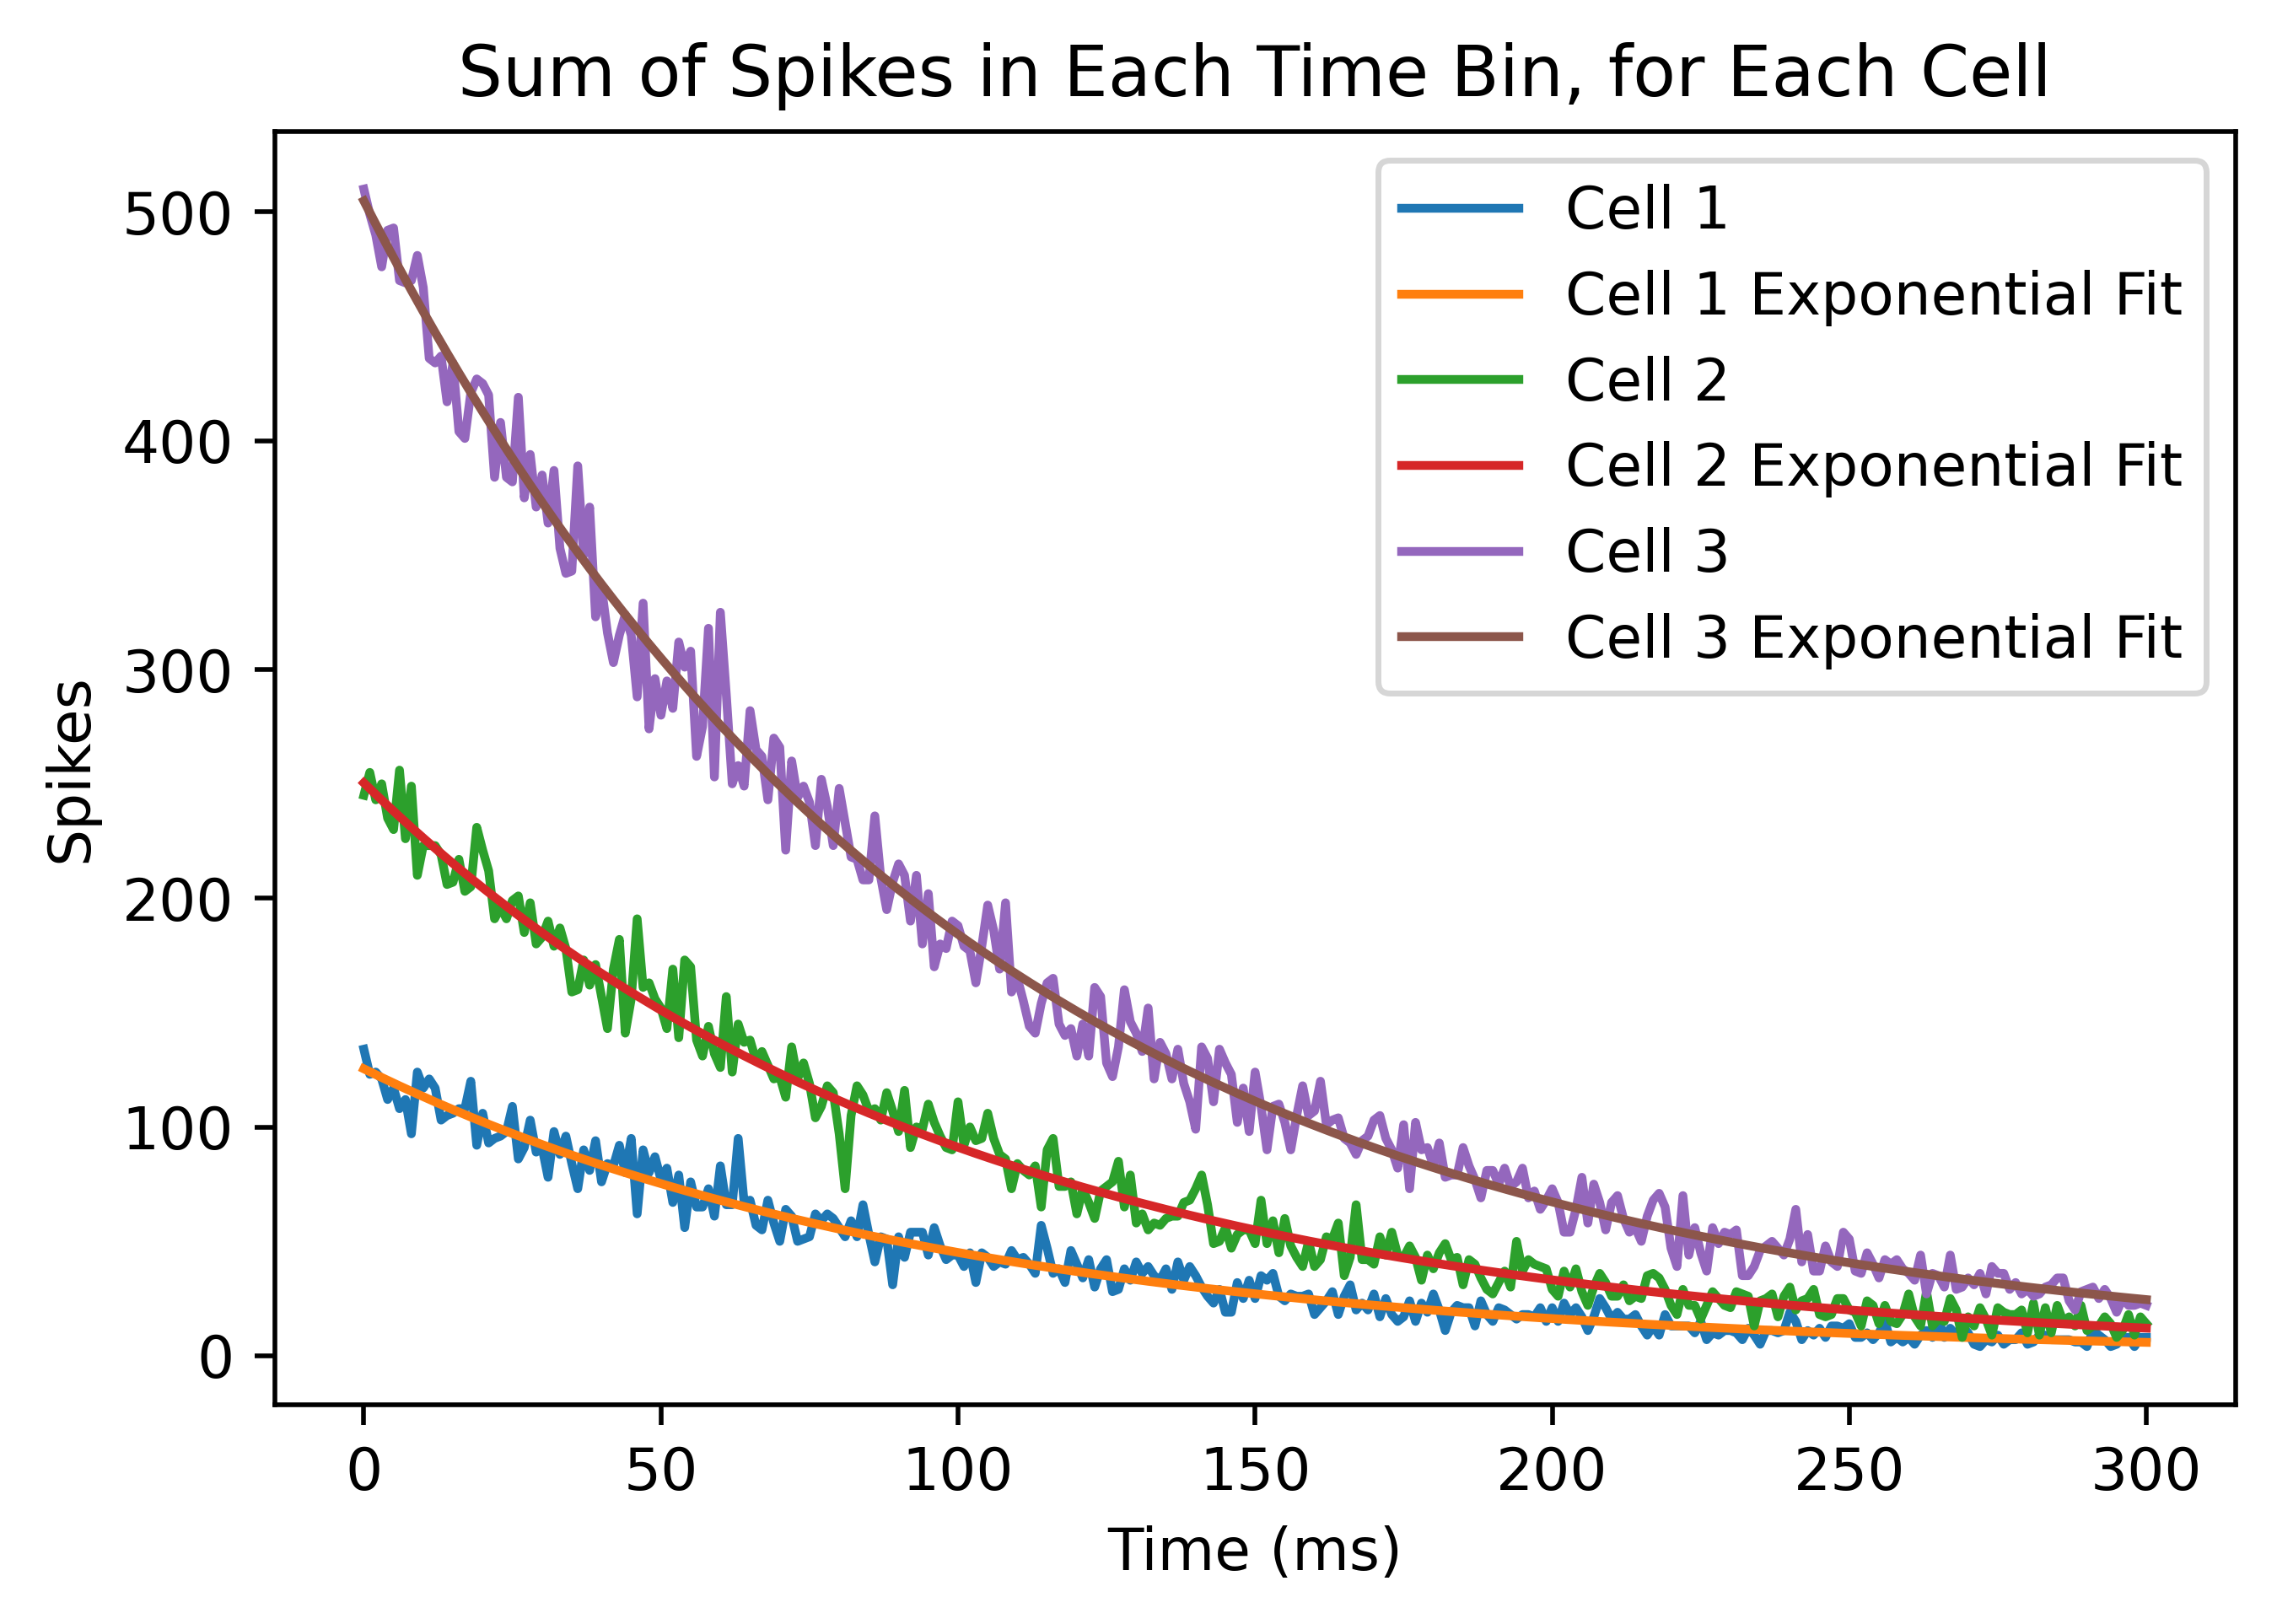

In [128]:
sum_timebins = np.sum(np.sum(spiketrain, axis = 0), axis = 1)
for i in np.arange(3):
    plt.plot(sum_timebins[:,i], label = 'Cell ' + str(i + 1))
    k = plt.polyfit(np.arange(nmsec),np.log(sum_timebins[:,i]), 1)
    plt.plot(np.arange(nmsec), np.exp(k[0] * np.arange(nmsec) + k[1]), label = 'Cell ' + str(i + 1) + ' Exponential Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spikes')
plt.title('Sum of Spikes in Each Time Bin, for Each Cell')
plt.legend()


## 3.

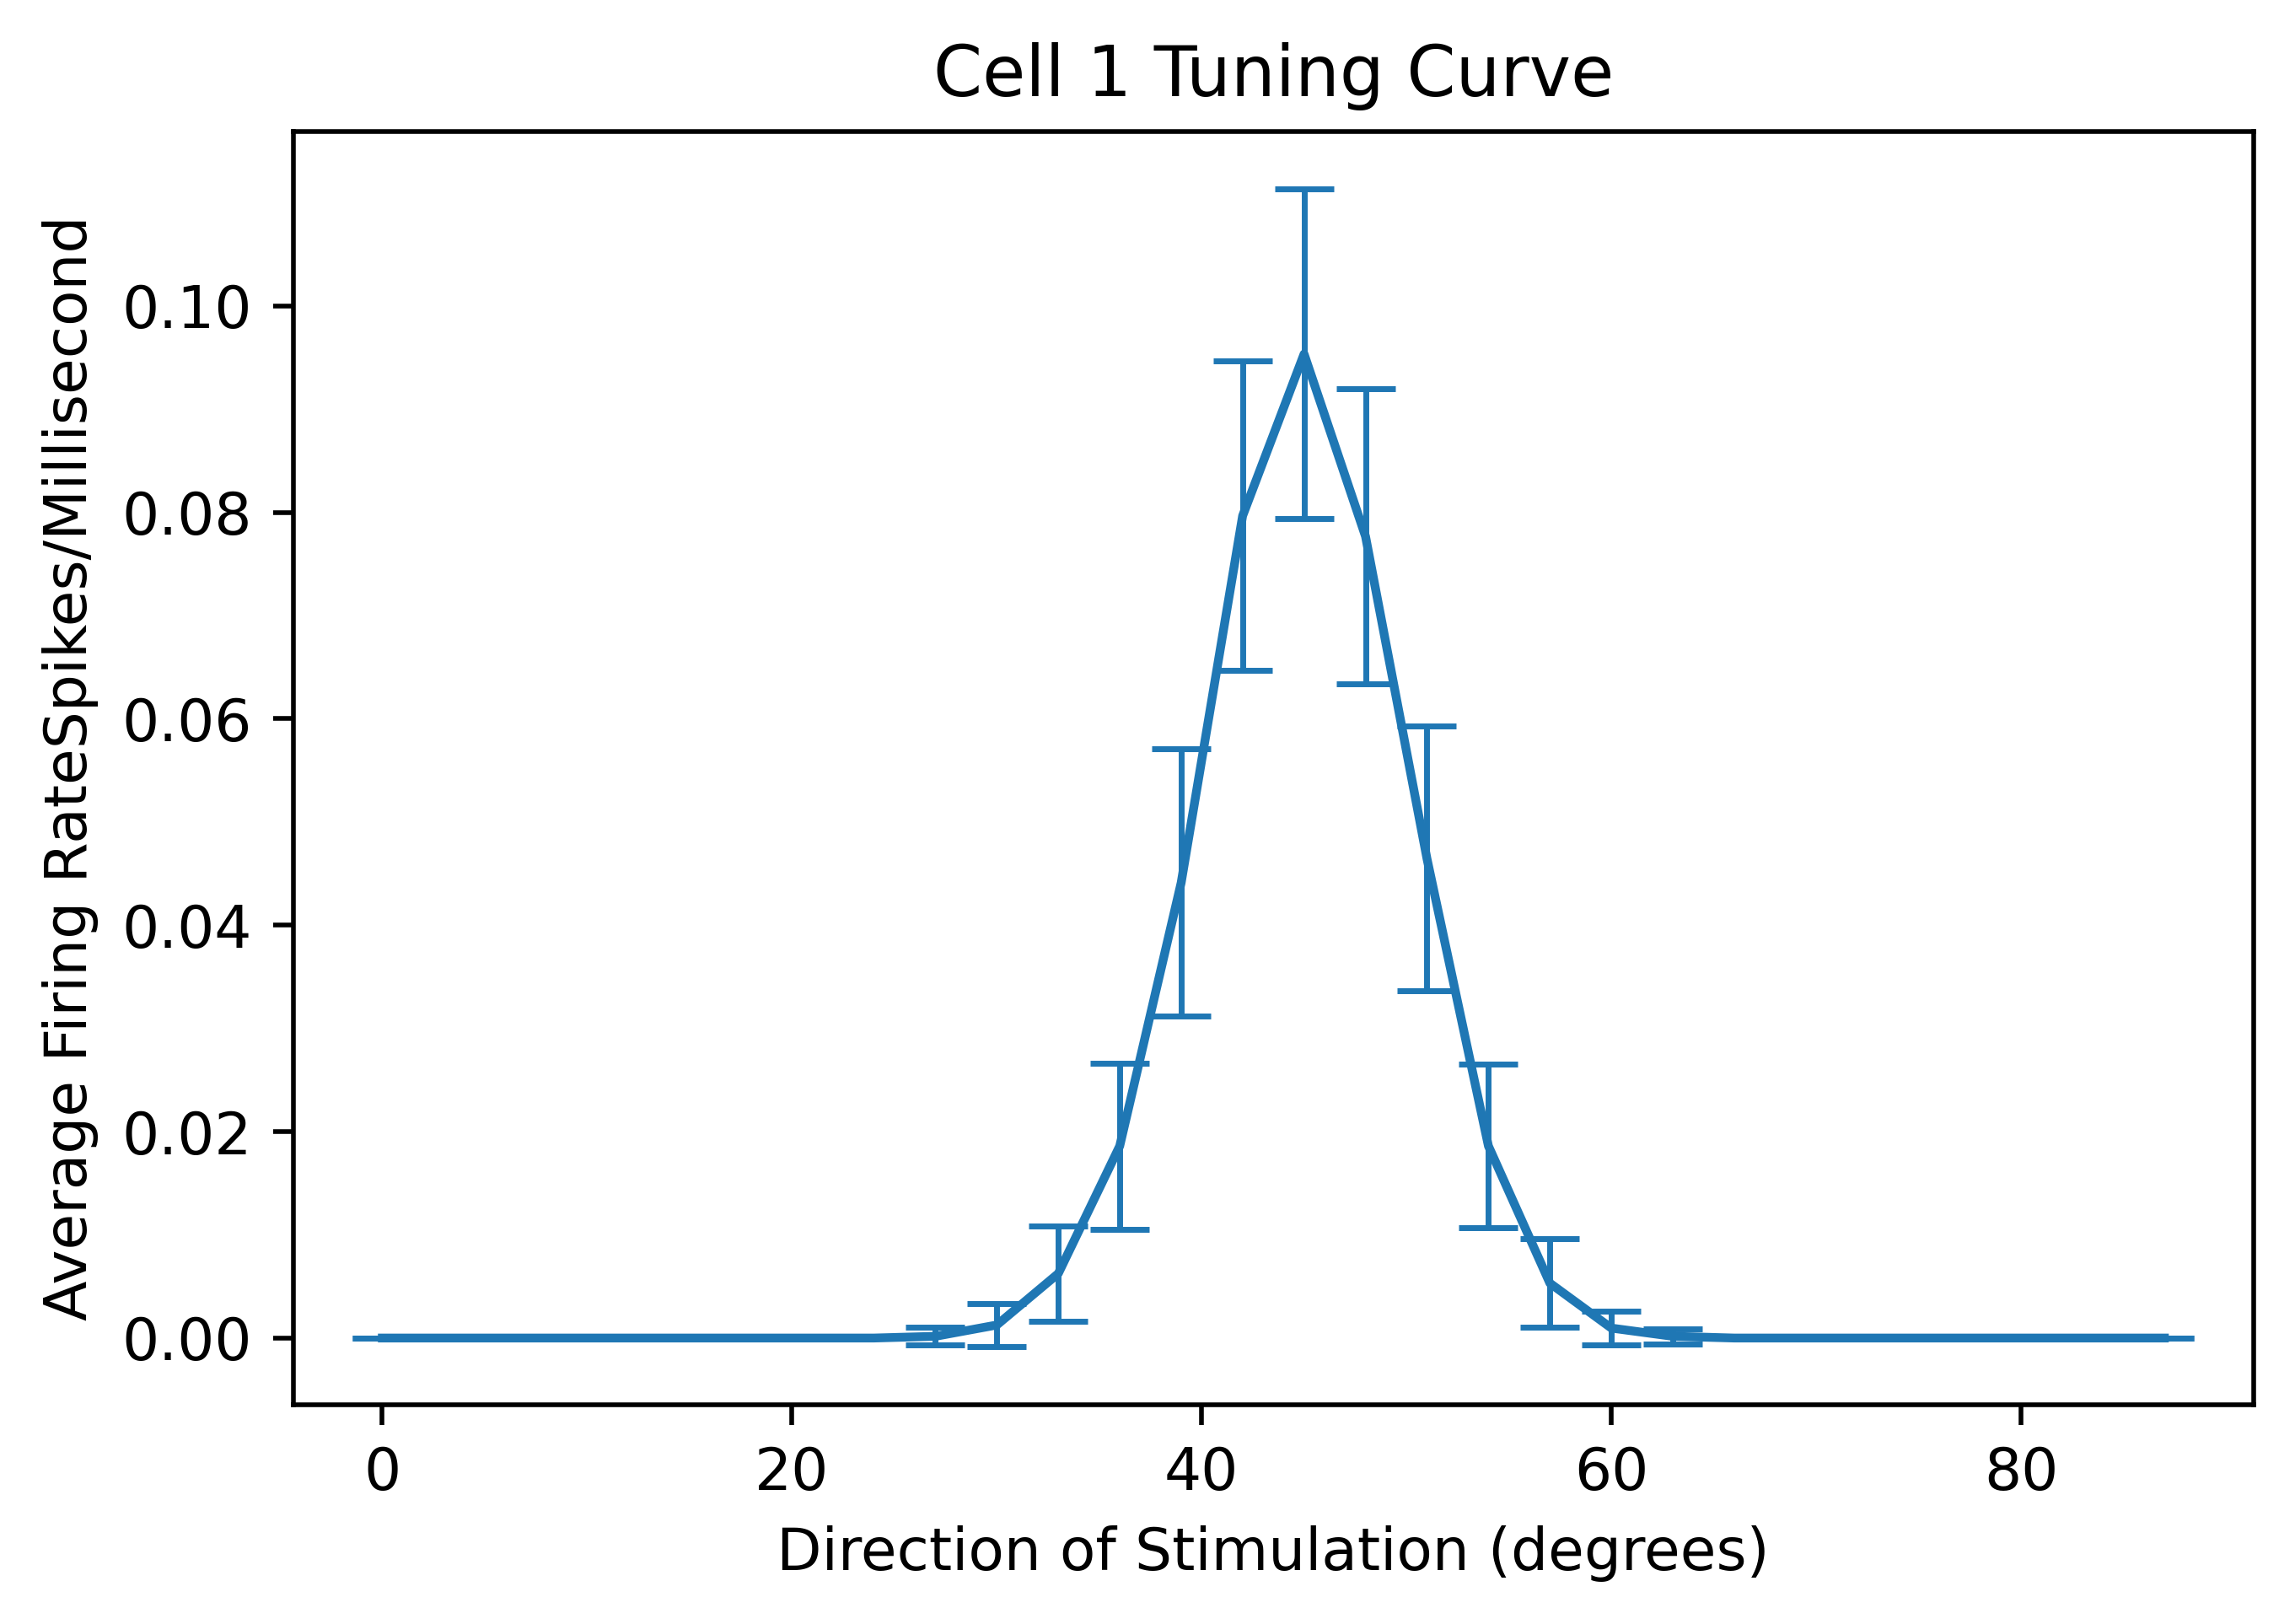

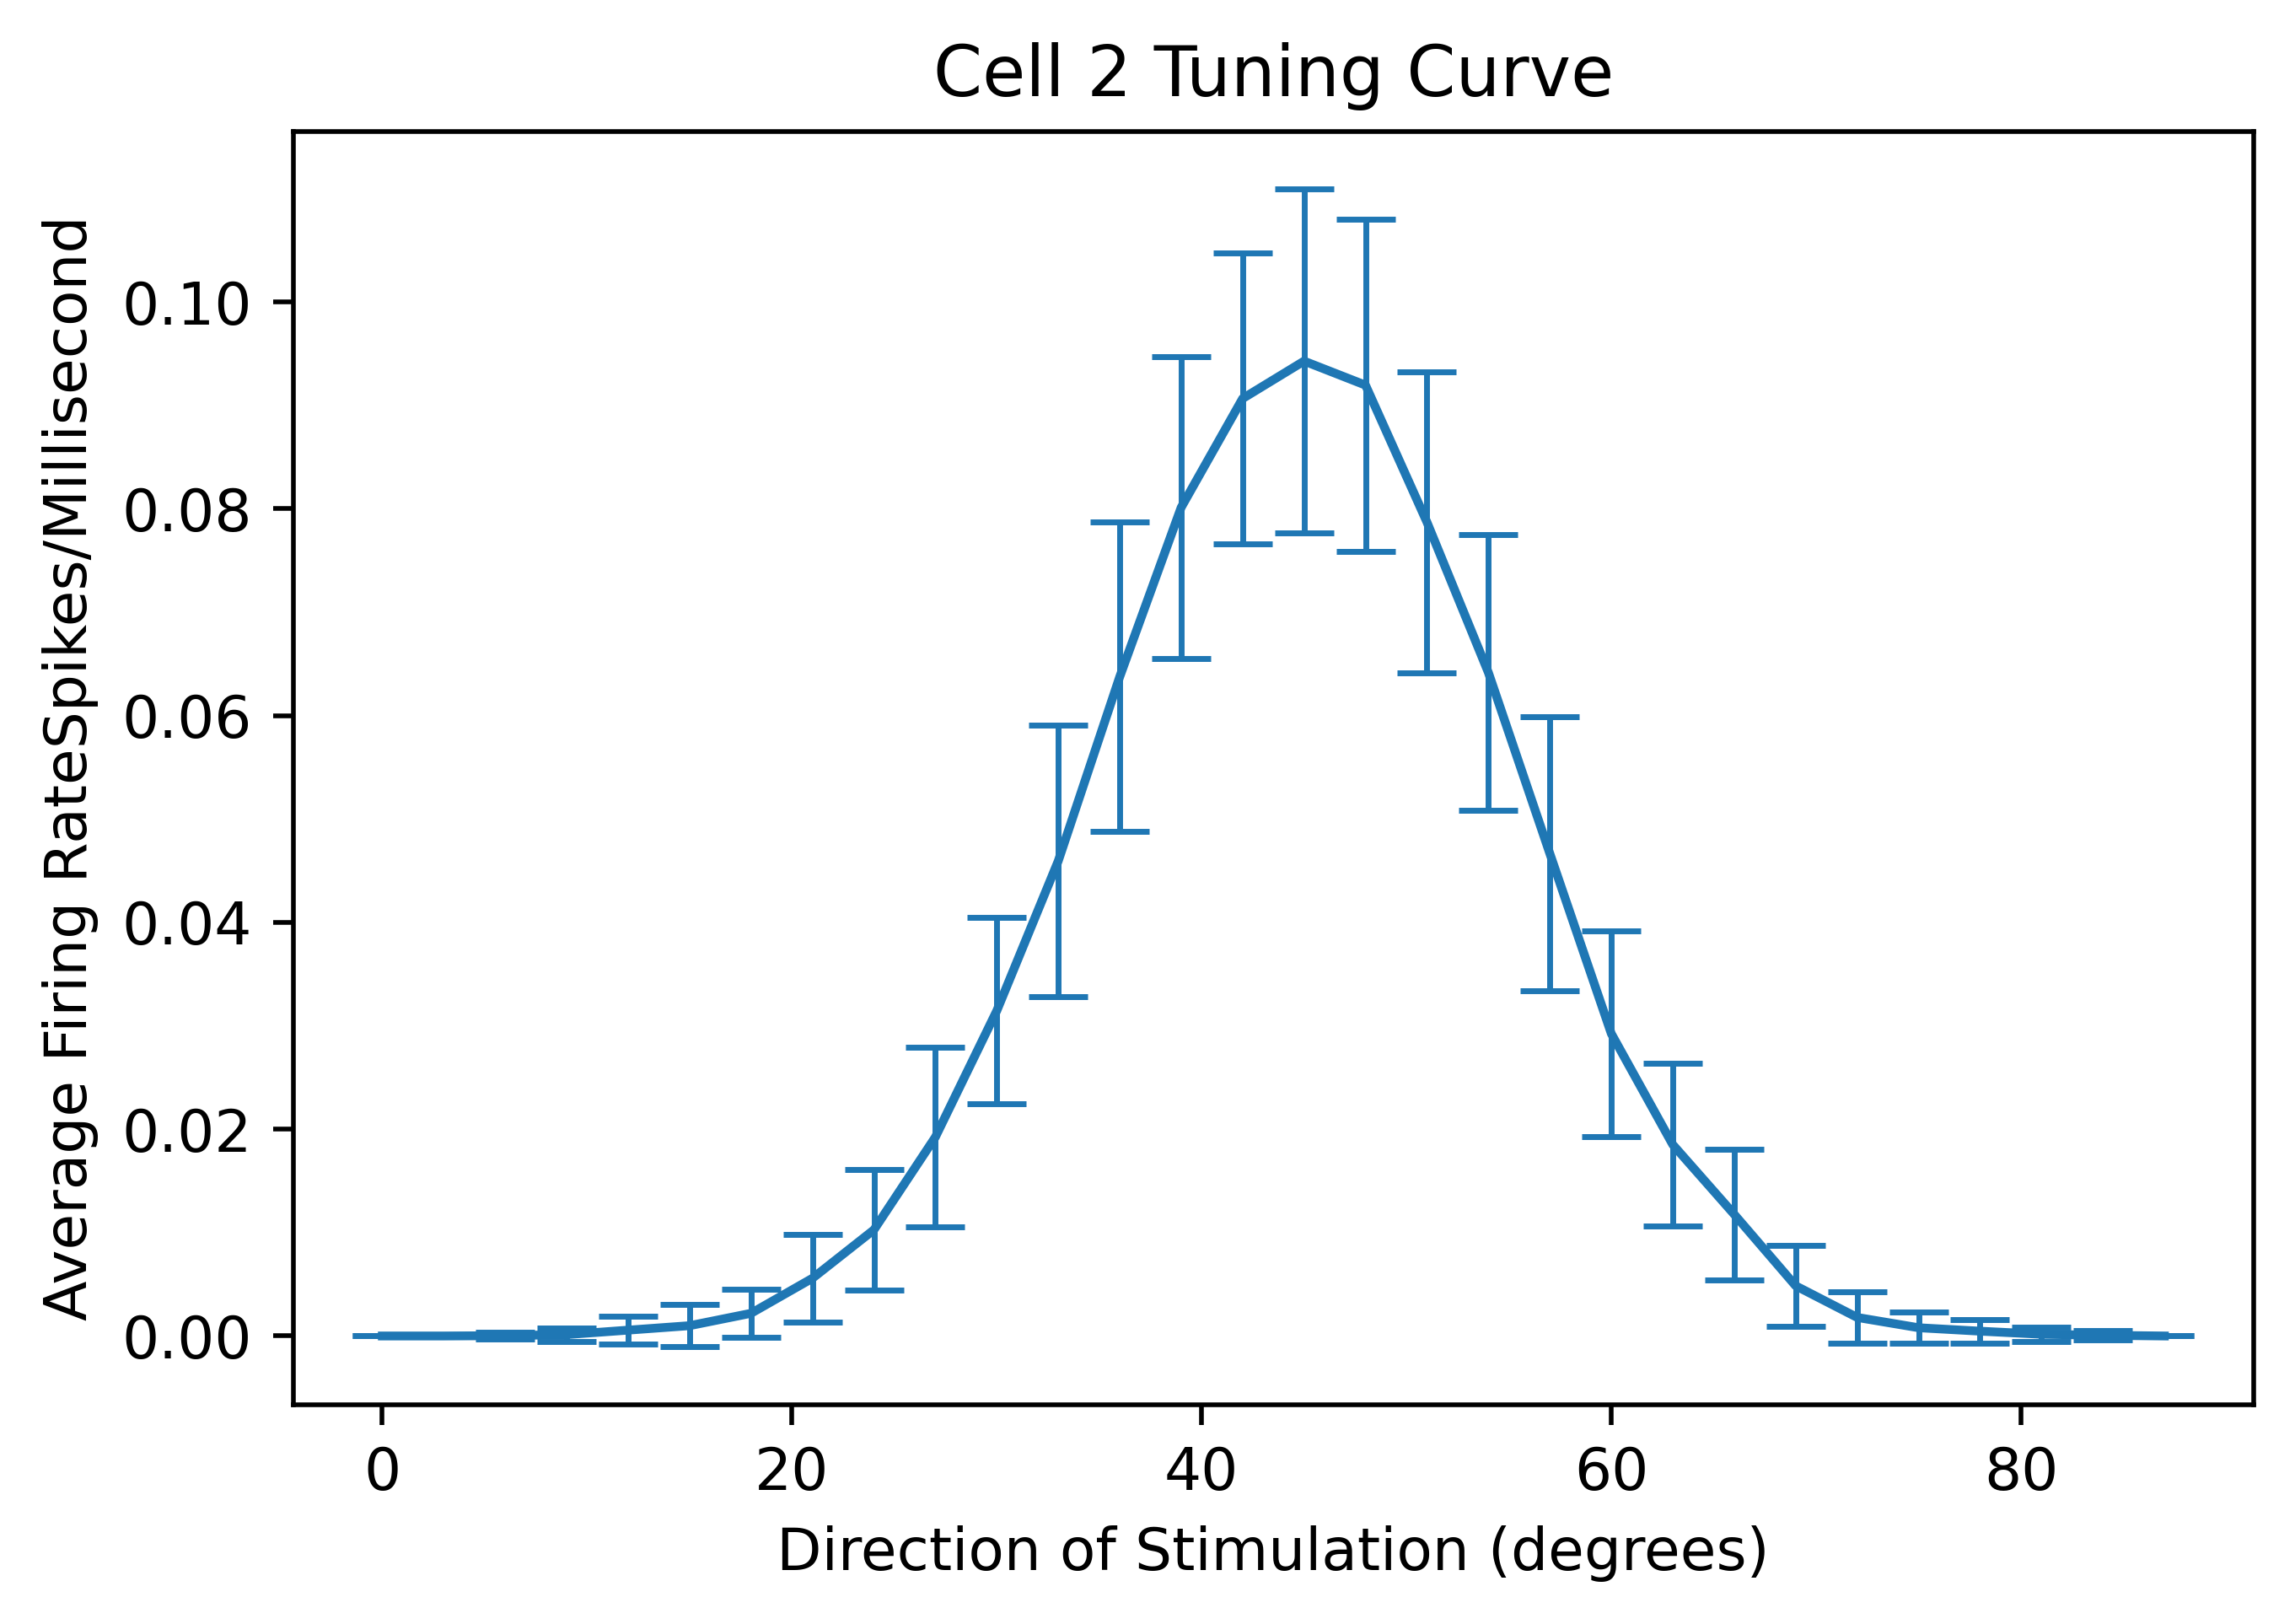

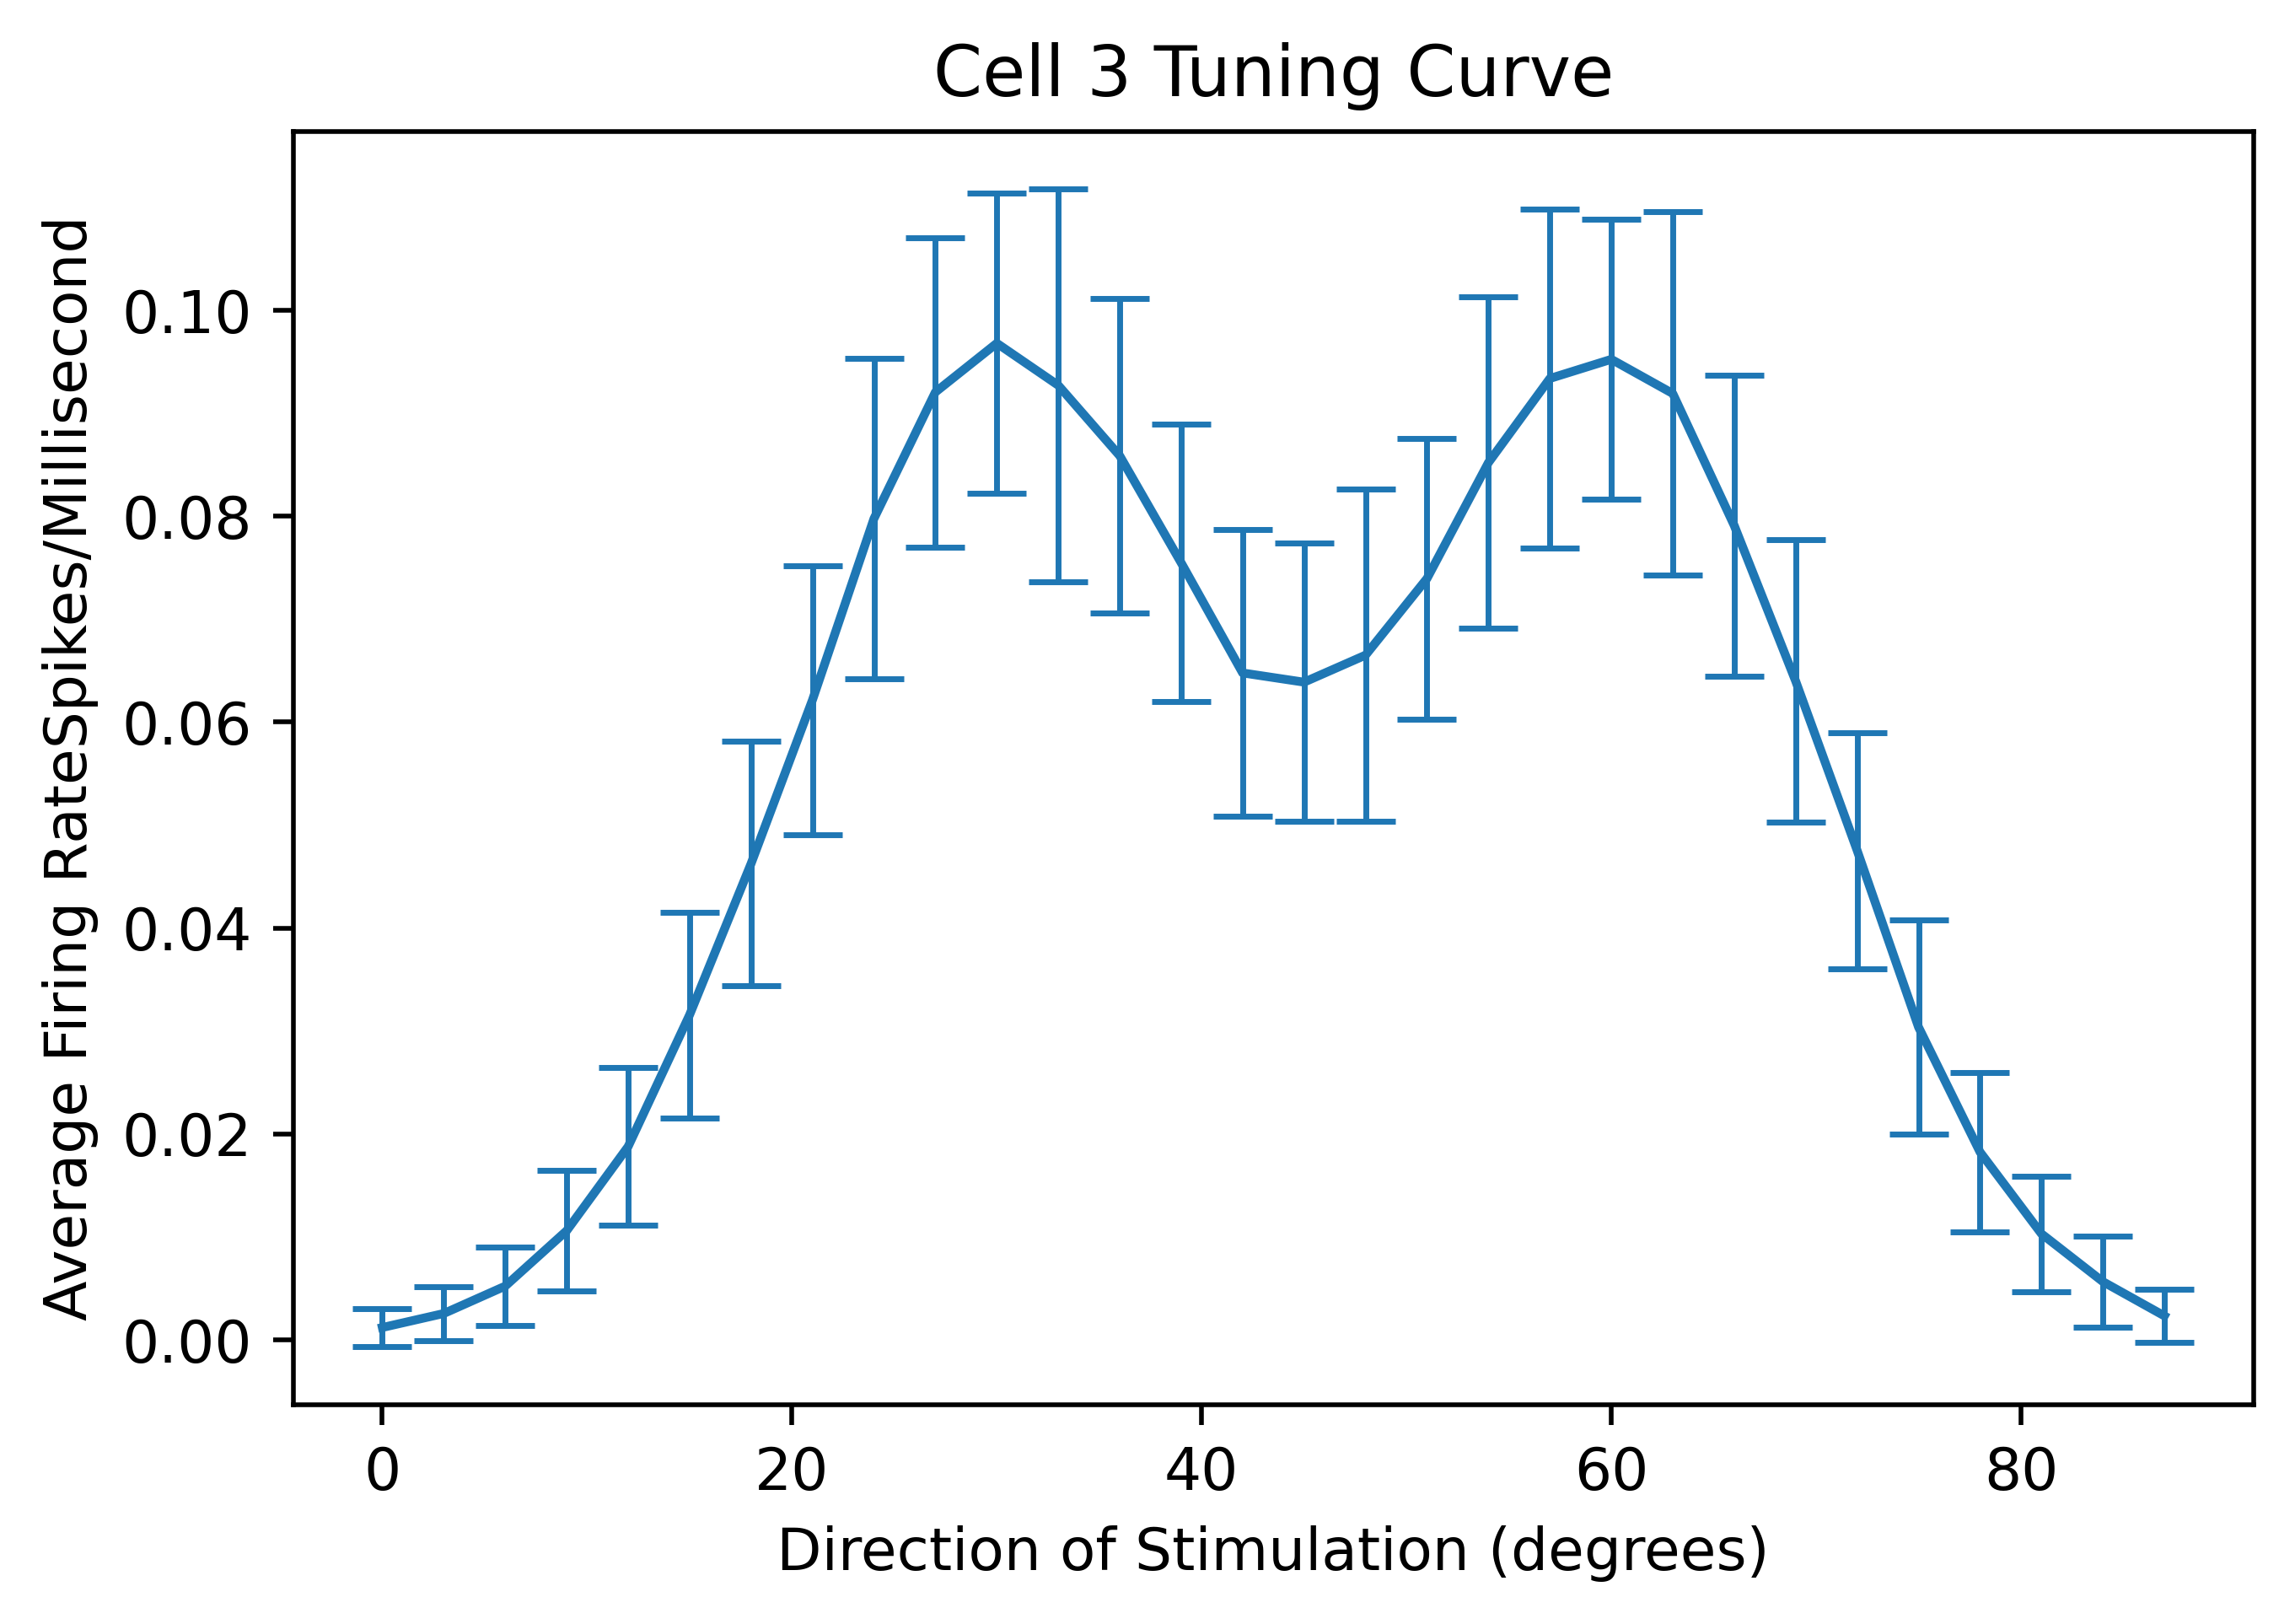

In [129]:
for j in np.arange(numCells):
    # plt.subplot(numCells,1,j + 1)
    plt.figure(j)
    plt.errorbar(np.linspace(0,maxDir - maxDir/numDirs,numDirs), means[:,j], elinewidth = 1,yerr = stds[:,j]) # -maxDir / numDirs is to remove the  degree angle, which isn't included in the original data, and will cause the plot to be off-center and incorrect
    plt.xlabel('Direction of Stimulation (degrees)')
    plt.ylabel('Average Firing RateSpikes/Millisecond')
    plt.title('Cell ' + str(j + 1) + ' Tuning Curve')